# **Importing All packages**

In [2]:
import tensorflow as tf
import keras
from keras import layers, regularizers, optimizers
from keras.layers import Dense, Add, Flatten, Input, Activation, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Lambda, concatenate
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import cv2
import numpy as np
from numpy import load, save
import re
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# **Image Preprocessing**

In [0]:
## Reading training.csv file using pandas
train=pd.read_csv('/content/drive/My Drive/HUSE/training.csv')

In [0]:
train.head()

,image,name,classes
0,5da821eb7f3e301b4504bb4a_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
1,5da81cde7861c2af6a5a88cf_0.jpg,Marc Jacobs Beauty Eye-Conic Longwear Eyeshad...,beauty<makeup<eyeshadow
2,5da8219a6504fb65da0050aa_0.jpg,Prada Wool sweater,clothing<knitwear<fine knit
3,5da821856504fb65cea703cf_0.jpg,Prada Printed silk-satin twill straight-leg p...,clothing<pants<straight leg
4,5da82200b25b035d1d17bec6_0.jpg,Prada Cropped chain-trimmed printed crepe str...,clothing<pants<straight leg


There are three columns or features in training file. First column is image names of products which wee will use to read images, 2nd feature is name of the product and last feature is class or label.

In [0]:
## Randomly shuffling data 
train=shuffle(train)
train=train.reset_index(drop=True)

In [0]:
## Let's look at the shuffled data which will be used for preprocessing data.
train.head()

,image,name,classes
0,5da81e6d465e00845f490b5b_4.jpg,Acne Studios Lavinia shearling jacket,clothing<jackets<casual jackets
1,5e497e394c033d18b291a5b7_4.jpg,AMBUSH® Oversized tie-detailed printed cotton...,clothing<tops<t-shirts
2,5e4d39024c033d562da0e19c_1.jpg,ViX Spring Romance shirred floral-print stret...,clothing<beachwear<coverups
3,5da81accb25b035d1d17a519_1.jpg,Balmain Double-breasted wool-twill blazer,clothing<jackets<blazers
4,5da8218fb25b035d1d17b7e8_1.jpg,Max Mara Kenia wool-twill wide-leg pants,clothing<pants<wide leg


In [0]:
## Now we are going to read images 
from tqdm import tqdm  
path='/content/drive/My Drive/Colab Notebooks/netaporter_gb_images' ## location of extracted images
train_images=[]                   ## creating empty list to save images 
def create_train():               ## Defining a function to create training data over images.
  for img in tqdm(train['image']):       ## Iterating over all the image names in train['image'] to read images
    final_path=os.path.join(path,img)    ## Joining path with images to get full path of images 
    train_img=cv2.imread(final_path)     ## reading images using cv2
    img_arr=cv2.resize(train_img,(64,64)) ## We will resize our images to be a (64,64) images.
    train_images.append(img_arr)       ## Saving resized image in train_images list. This proces repeated untill we reach last image name.
create_train()   ## Now calling our create function to get list
print(len(train_images)) ## Printing length of train_images to see number of images in our dataset

100%|██████████| 65714/65714 [20:53<00:00, 52.40it/s]

65714


In [0]:
## Let's look at the unique classes in training data
train['classes'].unique()

array(['clothing<jackets<casual jackets', 'clothing<tops<t-shirts',
       'clothing<beachwear<coverups', 'clothing<jackets<blazers',
       'clothing<pants<wide leg', 'clothing<dresses<mini',
       'bags<tote bags<tote bags', 'clothing<skirts<midi',
       'clothing<tops<tanks and camis', 'clothing<knitwear<medium knit',
       'shoes<pumps<mid heel', 'clothing<jumpsuits<full length',
       'clothing<tops<blouses', 'clothing<dresses<maxi',
       'clothing<dresses<gowns', 'accessories<wallets<cardholders',
       'jewelry and watches<fine jewelry<earrings',
       'bags<shoulder bags<cross body', 'clothing<dresses<knee length',
       'jewelry and watches<fine jewelry<rings', 'beauty<makeup<lipstick',
       'clothing<dresses<midi', 'shoes<sneakers<low top',
       'bags<shoulder bags<shoulder bags',
       'jewelry and watches<fashion jewelry<necklaces',
       'clothing<tops<shirts', 'shoes<boots<ankle',
       'beauty<makeup<foundation', 'clothing<knitwear<fine knit',
       'sho

In [0]:
## Looking at nummber of classes 
train['classes'].nunique()

48

We have 48 unique classes 

In [0]:
## Creating numerical labels of classes in our data
train['classes']=train['classes'].astype('category')
train['labels']=train['classes'].cat.codes

In [0]:
train.head()

,image,name,classes,labels
0,5da81e6d465e00845f490b5b_4.jpg,Acne Studios Lavinia shearling jacket,clothing<jackets<casual jackets,21
1,5e497e394c033d18b291a5b7_4.jpg,AMBUSH® Oversized tie-detailed printed cotton...,clothing<tops<t-shirts,31
2,5e4d39024c033d562da0e19c_1.jpg,ViX Spring Romance shirred floral-print stret...,clothing<beachwear<coverups,11
3,5da81accb25b035d1d17a519_1.jpg,Balmain Double-breasted wool-twill blazer,clothing<jackets<blazers,20
4,5da8218fb25b035d1d17b7e8_1.jpg,Max Mara Kenia wool-twill wide-leg pants,clothing<pants<wide leg,26


We have now numerical labels to work on

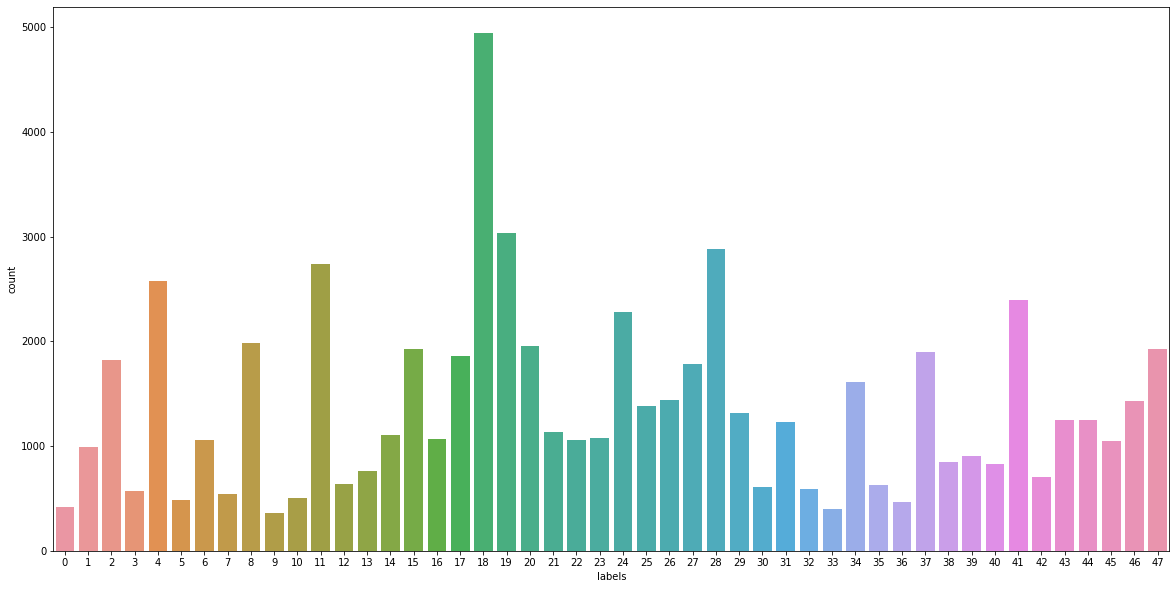

In [0]:
## Let's have a look at the label distribution
plt.figure(figsize=(20,10))
sns.countplot(train['labels'])

As you can see label 18 has been occured most number of times which is around 5000. There are many labels that occured for less than 1000 times. There are seven labels which occured for more than 2000 times. Which means Precision, Recall and F1-score parameters could also be used in this scenario along with accuracy. However I am only using accuracy parameter in this assignment.

In [0]:
## Now let's create an array of training labels.
train_labels=train['labels']
train_labels=np.array(train_labels)

In [0]:
train_labels.shape

(65714,)

However our training_label does not have an appropriate shape (65714,) so we will reshape it in an appropriate shape


In [0]:
## Reshaping training_label to get appropriate format
train_labels=train_labels.reshape(train_labels.shape[0],-1)

In [0]:
train_labels.shape

(65714, 1)

We have 48 labels. Hence we need to one hot encoding inorder to do classification

In [0]:
train_labels=np.eye(48)[train_labels.reshape(-1)] ## np.eye() will create an Identity Matrix which will use training labels as index to
## get one hot representation. For example if everytime label 0 appears first column will be one else zero. Simillarly for other classes.

In [0]:
train_labels.shape

(65714, 48)

Now we have one hot encoding of labels 

In [0]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We have stored images in a list. But to run algorithms on top of our data we need an array of a shape like (None,height,width,channels). Where None is nothing but representaion of number of images, Height and Width are image size(pixels) and channels is used to represnt a graysacale or RGB images. If it's a grayscale image then it will be 1, if image is RGB then channel will be 3. So we will convert our image data in this format.

In [0]:
## Converting our train_images data from list to an array
train_images=np.array(train_images)

In [0]:
train_images.shape

(65714, 64, 64, 3)

Now we have an appropriate format of image data to run algorithms. In next step we will divide our data into training and testing 

In [0]:
X_train=train_images[0:60000,:,:,:]
Y_train=train_labels[0:60000,:]
X_test=train_images[60000:,:]
Y_test=train_labels[60000:,:]

In [0]:
X_train.shape

(60000, 64, 64, 3)

In [0]:
Y_train.shape

(60000, 48)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
clothing<tops<t-shirts
AMBUSH®  Oversized tie-detailed printed cotton-jersey T-shirt  


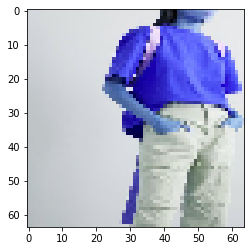

In [0]:
## Let's look at one image with it's class and label
plt.imshow(train_images[1])
print(train_labels[1])
print(train['classes'].iloc[1])
print(train['name'].iloc[1])

Saving preprocessesd image data for future use

In [0]:
## Saving Data for future use
#save('/content/drive/My Drive/train.npy',X_train)
#save('/content/drive/My Drive/test.npy',X_test)
#save('/content/drive/My Drive/label_train.npy',Y_train)
#save('/content/drive/My Drive/label_test.npy',Y_test)

You can load your data by using below code.

In [0]:
X_train=load('/content/drive/My Drive/data ecommerce /train.npy')
X_test=load('/content/drive/My Drive/data ecommerce /test.npy')
Y_train=load('/content/drive/My Drive/data ecommerce /label_train.npy')
Y_test=load('/content/drive/My Drive/data ecommerce /label_test.npy')

Normalizing data by dividing 255. Reason for dividing 255 is that pixel value ranges from 0 to 255. It will give us values between 0 and 1.

In [0]:
X_train=X_train/255 ## Normalizing train data

In [0]:
X_test=X_test/255   ## Normalizing test data

24


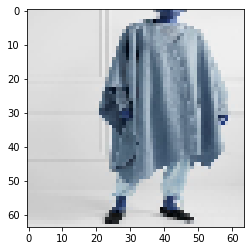

In [0]:
plt.imshow(X_train[10])
print(np.argmax(Y_train[10]))


# **Text PreProcessing**

In [0]:
## Extracting product names from our dataframe
names=np.array(train['name'])

In [0]:
names

array(['Acne Studios  Lavinia shearling jacket  ',
       'AMBUSH®  Oversized tie-detailed printed cotton-jersey T-shirt  ',
       'ViX  Spring Romance shirred floral-print stretch-crepe jumpsuit  ',
       ...,
       'Balenciaga  Track 2 logo-detailed metallic mesh and rubber sneakers   ',
       'Alaïa  Bombe studded suede sandals  ',
       'Alaïa  Marie-Jene mini laser-cut leather bucket bag  '],
      dtype=object)

We will define a clean function whih will remove puntuation marks, numbers and Extra spaces from end of the sentence. It will also replace upper case letters into lowe case

In [0]:
def clean_text(data):
  ## In this step we are converting charecters into lower case
  for i in range(data.shape[0]):
    data[i]=data[i].lower()
  ## In this step we are removing numbers and puntuation marks from text
  for i in range(data.shape[0]):
    data[i]=re.sub('[^A-Za-z" "]+', '', data[i])
  ## Here, we are removing extra space from the end of the sentence
  for i in range(data.shape[0]):
    data[i]=data[i].rstrip()
  return data

In [0]:
## Applying clean_text function to get clean text data
names=clean_text(names)

In [0]:
names

array(['acne studios  lavinia shearling jacket',
       'ambush  oversized tiedetailed printed cottonjersey tshirt',
       'vix  spring romance shirred floralprint stretchcrepe jumpsuit',
       ...,
       'balenciaga  track  logodetailed metallic mesh and rubber sneakers',
       'alaa  bombe studded suede sandals',
       'alaa  mariejene mini lasercut leather bucket bag'], dtype=object)

 **Compare the data before cleaning and after cleaning bold text**
 
 **Before Cleaning :** 
'Balenciaga  Track 2 logo-detailed metallic mesh and rubber sneakers   '

 **After Cleaning :**  
'balenciaga  track  logodetailed metallic mesh and rubber sneakers'

You can see that we have changed uppercase letters and removed numbers, puntuation marks and extra spaces from end of the sentence.

In [0]:
# The maximum number of words to be used.
MAX_NB_WORDS = 5000
# Max number of words in each name.
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 100

In [0]:
# Generating Word tokens
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(names)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7324 unique tokens.


We have 7324 unique tokens which we will use to train our text model.

In [0]:
# Let's look at the tokens
word_index

{'dress': 1,
 'leather': 2,
 'and': 3,
 'midi': 4,
 'gold': 5,
 'karat': 6,
 'mini': 7,
 'printed': 8,
 'crepe': 9,
 'floralprint': 10,
 'sandals': 11,
 'pants': 12,
 'bag': 13,
 'suede': 14,
 'tote': 15,
 'earrings': 16,
 'the': 17,
 'diamond': 18,
 'belted': 19,
 'shoulder': 20,
 'sweater': 21,
 'wool': 22,
 'boots': 23,
 'maxi': 24,
 'de': 25,
 'ruffled': 26,
 'top': 27,
 'satin': 28,
 'gown': 29,
 'gucci': 30,
 'skirt': 31,
 'ankle': 32,
 'sneakers': 33,
 'blazer': 34,
 'metallic': 35,
 'striped': 36,
 'blouse': 37,
 'coat': 38,
 'cottonblend': 39,
 'shirt': 40,
 'silk': 41,
 'embellished': 42,
 'pumps': 43,
 'oversized': 44,
 'woolblend': 45,
 'chlo': 46,
 'chine': 47,
 'beauty': 48,
 'lip': 49,
 'texturedleather': 50,
 'prada': 51,
 'small': 52,
 'cottonjersey': 53,
 'valentino': 54,
 'silksatin': 55,
 'wideleg': 56,
 'necklace': 57,
 'asymmetric': 58,
 'cotton': 59,
 'silkblend': 60,
 'pleated': 61,
 'draped': 62,
 'ml': 63,
 'leathertrimmed': 64,
 'rose': 65,
 'turtleneck': 66,

In [0]:
## Finally we are creating our text data for training
X = tokenizer.texts_to_sequences(names) # Here it takes each word from names and replaces it with it's corresponding number from our word_index
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) # it transforms list of sequences into numpy aray of shape (num_sequence,num_timestep) 
## Where num sequence is number of sentences in names and num_timestep is number of words in each sentence which is 15 in this case.
print('Shape of data tensor:', X.shape)

Shape of data tensor: (65714, 15)


In [0]:
# You can see here an array where for every example(sentence) we have 15 fetaures(words).
X

array([[   0,    0,    0, ..., 2634,  222,   69],
       [   0,    0,    0, ...,    8,   53,  101],
       [   0,    0,    0, ...,   10,  332,   72],
       ...,
       [   0,    0,    0, ...,    3,  350,   33],
       [   0,    0,    0, ...,  199,   14,   11],
       [   0,    0,    0, ...,    2,  228,   13]], dtype=int32)

In [0]:
## Now let's create train and test datasets
X_traintext=X[0:60000,:]
X_testtext=X[60000:,:]
print(X_traintext.shape,Y_train.shape)
print(X_testtext.shape,Y_test.shape)

(60000, 15) (60000, 48)
(5714, 15) (5714, 48)


Saving preprocessesd text data for future use

In [0]:
#save('/content/drive/My Drive/train_text.npy',X_traintext)
#save('/content/drive/My Drive/test_text.npy',X_testtext)

We can reload the text data by using below code

In [0]:
X_traintext=load('/content/drive/My Drive/data ecommerce /train_text.npy')
X_testtext=load('/content/drive/My Drive/data ecommerce /test_text.npy')

# **Image Embeddings**




This is part 1 of the assignment where we will use VGG16 pretrained model to get image embeddings.

In [15]:
new_model = VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3)) ## Loading VGG16 model with shape(64,64,3), 
## Excluding last layer and using imagenet weights.
model=Sequential()       ## Creating new model where we will load our vgg16 model
for layer in new_model.layers:
  model.add(layer)
for layer in model.layers: ## Setting layers of model to trianable as false
  layer.trainable=False
model.add(Flatten())       ## Adding a Flatten layer at the end to get a vector output

58892288/58889256 [==============================] - 2s 0us/step


In [16]:
## Now let's look at the summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

You can see Flatten layer at the end which outputs a 2048 dimensional vector. These 2048 embeddings will be passed to image tower later. Talking about the model you can see there are 14,714,688 total parameters but trainable parameters are 0 as wee don't want to train VGG16 model.

# **Implementinng Image Tower**

Now we will implement part 2 image tower. Here we have taken refernce from "4.1.3 Training Process" of paper to build image tower. We have also taken refernce from "3.2. Network Structure" third paragraph Which is "The text tower and image tower can have different number of hidden layers and different hidden layer sizes. The only restriction is that the last layer of both towers should have D hidden units followed by L2 normalization"


In [0]:
## Creating image_tower model
## As defined in paper we are going to use 5 hidden Dense layer with 512 units each
## A dropout of 0.15 is used between all hidden layers.
## L2 normalization is used 
image_tower=Sequential()
image_tower.add(Dense(512,activation='softmax'))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512,activation='softmax'))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512,activation='softmax'))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512,activation='softmax'))
image_tower.add(Dropout(0.15))
image_tower.add(Dense(512,activation='softmax'))   ## Last layer with D=512 hidden units followed by L2 normalization.
image_tower.add(Lambda(lambda xz:K.l2_normalize(xz,axis=1))) ## Normalizing 

Now we will add our image_tower model to image embedding model

In [0]:
model.add(image_tower)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

As you can see there are 14,714,688 non-trainable parameters from previous model and 2,099,712 new parameters from image_tower model which are trainable. Last layer 'sequential_2' represents image_tower model.

# **Text Embeddings**

Part 1 text embedding. Here we have decided to train a small model for text embedding rather than using pretrained model. This model will be traind and it will pass text embeddings to text_tower.

In [0]:
## Creating textmodel 
textmodel=Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
textmodel.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,input_length=X_traintext.shape[1]))
textmodel.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
textmodel.add(Conv1D(256,
                 5,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
textmodel.add(GlobalMaxPooling1D())

# We add a Fully Connected hidden layer:
textmodel.add(Dense(512))
textmodel.add(Dropout(0.2))
textmodel.add(Activation('relu'))

In [21]:
## Now look at the summary of this model
textmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           500000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 256)           128256    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)              

So we have 7 layers in this model and 759,840 parameters which are trainable. And last layer will pass text embeddings to text tower.

# **Implementing Text tower**

Now we will implement part 2 text tower. Here we have taken refernce from "4.1.3 Training Process" of paper to build text tower. We have also taken refernce from "3.2. Network Structure" third paragraph Which is "The text tower and image tower can have different number of hidden layers and different hidden layer sizes. The only restriction is that the last layer of both towers should have D hidden units followed by L2 normalization"


In [0]:
## Creating text_tower model
## As defined in paper we are going to use 2 hidden Dense layer with 512 units each
## A dropout of 0.15 is used between all hidden layers.
## L2 normalization is used
text_tower=Sequential()
text_tower.add(Dense(512,activation='relu'))
text_tower.add(Dropout(0.15))
text_tower.add(Dense(512,activation='relu'))  ## Last layer with D=512 hidden units followed by L2 normalization.
text_tower.add(Lambda(lambda xz:K.l2_normalize(xz,axis=1))) ## L2 normalizaton.

Now we will add text_tower model to text embedding model

In [0]:
## Adding text_tower to textmodel
textmodel.add(text_tower)

In [24]:
## Let's see textmodel now.
textmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           500000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 256)           128256    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)              

As you can see there are total 1,285,152 parameters and all parameters are set to be trainable. The last layer which is 'sequential_4' represents text_tower model.

# **Final Model**

Now we will merge both the models and add final layer for classification

In [0]:
merged=concatenate([model.output,textmodel.output]) ## Merging both the models
out=Dense(48)(merged) ## Adding a Dense layer to merged layers
out=Activation('softmax')(out) ## Adding activation softmax for classification
final_model=Model([model.input,textmodel.input],out) ## Final model which we will use for classification

In [26]:
## Let's have a look at the final model.
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[1][0]               
____________________________________________________________________________________________

Look at the 'sequential_2' layer it is the output from image_tower simillarly 'sequential_4' is the output from text_tower. These layers are merged(concatenated) into 'concatenate_1' layer. In final_model we have a total of 18,148,752 parameters out of which onlt 3,434,064 are trainable. 14,714,688 parameters are non-trainable which are from VGG16 model. This model will be used further for classification.

# **Class Level Similarity**

As defined in "4.1.3 Training Process" we will use RMSprop optimization with learning_rate=1.6192e-5. We will use "categorical_crossentropy" as written in "3.4.1 Class Level Similarity"

In [0]:
final_model.compile(optimizer=optimizers.RMSprop(lr=1.6192e-5),loss='categorical_crossentropy',metrics=['accuracy'])

We are definining a callback which will stop training after we have achieved the accuracy of 98% or greater on validation set.

In [0]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>=0.98):
      print("\n Reached accuracy of 98% hence stopping training")
      self.model.stop_training=True
callbacks=myCallback()

Finally training our model

In [29]:
final_model.fit([X_train,X_traintext],Y_train,batch_size=256,epochs=200,validation_split=0.05,callbacks=[callbacks])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 57000 samples, validate on 3000 samples
Epoch 1/200
57000/57000 [==============================] - 18s 311us/step - loss: 3.8259 - accuracy: 0.0569 - val_loss: 3.7845 - val_accuracy: 0.0853
Epoch 2/200
57000/57000 [==============================] - 16s 276us/step - loss: 3.7592 - accuracy: 0.0821 - val_loss: 3.7192 - val_accuracy: 0.1197
Epoch 3/200
57000/57000 [==============================] - 16s 276us/step - loss: 3.6862 - accuracy: 0.1555 - val_loss: 3.6391 - val_accuracy: 0.2067
Epoch 4/200
57000/57000 [==============================] - 16s 276us/step - loss: 3.6043 - accuracy: 0.2172 - val_loss: 3.5566 - val_accuracy: 0.2500
Epoch 5/200
57000/57000 [==============================] - 16s 277us/step - loss: 3.5209 - accuracy: 0.2676 - val_loss: 3.4723 - val_accuracy: 0.3177
Epoch 6/200
57000/57000 [==============================] - 16s 277us/step - loss: 3.4358 - accuracy: 0.3297 - val_loss: 3.3866 - val_accuracy: 0.3663
Epoch 7/200
57000/57000 [==========================

Evaluating model on test set

In [30]:
final_model.evaluate([X_test,X_testtext],Y_test)

5714/5714 [==============================] - 2s 405us/step


[0.08105746813126281, 0.9821491241455078]

In [0]:
final_model.save('/content/drive/My Drive/cross_model.h5')

In [0]:
final_model.save_weights('/content/drive/My Drive/cross_model_weights.h5')

# **Semantic Similarity**

In [0]:
## Extracting unique classes from training dataframe
classes=np.array(train['classes'].unique())

In [0]:
def clean_text(data):
  ## In this step we are converting charecters into lower case
  for i in range(data.shape[0]):
    data[i]=data[i].lower()
  ## Replacing "<" with " " (white spaces)
  for i in range(data.shape[0]):
    data[i]=data[i].replace('<'," ")
  ## In this step we are removing numbers and puntuation marks from text
  for i in range(data.shape[0]):
    data[i]=re.sub('[^A-Za-z" "]+', '', data[i])
  ## Here, we are removing extra space from the end of the sentence
  for i in range(data.shape[0]):
    data[i]=data[i].rstrip()
  return data

In [0]:
## Cleaning the classes
classes=clean_text(classes)

In [0]:
classes

array(['beauty makeup eyeshadow', 'clothing knitwear fine knit',
       'clothing pants straight leg', 'clothing tops blouses',
       'shoes sandals flat', 'clothing jumpsuits full length',
       'shoes sandals high heel', 'beauty makeup lipstick',
       'beauty makeup foundation', 'beauty makeup lipgloss',
       'beauty skincare moisturizer', 'shoes pumps mid heel',
       'clothing beachwear onepiece', 'shoes sneakers low top',
       'clothing dresses gowns', 'clothing dresses midi',
       'clothing tops shirts', 'clothing tops tanks and camis',
       'clothing jackets blazers', 'clothing tops tshirts',
       'jewelry and watches fashion jewelry necklaces',
       'shoes sandals mid heel',
       'jewelry and watches fine jewelry necklaces',
       'jewelry and watches fashion jewelry earrings',
       'jewelry and watches fine jewelry rings', 'beauty skincare serum',
       'jewelry and watches fine jewelry earrings',
       'bags shoulder bags shoulder bags', 'bags tote bag

We will use same word tokens here that we used for text model. 

In [0]:
X = tokenizer.texts_to_sequences(classes) # Here it takes each word from classes and replaces it with it's corresponding number from our tokenizer word_index
X = pad_sequences(X, maxlen=10) # it transforms list of sequences into numpy aray of shape (num_sequence,num_timestep) 
## In this case num_sequence=48 as we have 48 classes and num_timestep=10.
print('Shape of data tensor:', X.shape)

Shape of data tensor: (48, 10)


We will use cosine_similarity to find the similarity between the classes

In [0]:
semantic_sim=cosine_similarity(X)

In [0]:
semantic_sim.shape

(48, 48)

In [0]:
## Let's see similarity of 2nd class
semantic_sim[1]

array([0.56750939, 1.        , 1.        , 0.        , 1.        ,
       1.        , 0.99980986, 0.16981106, 0.14891433, 0.99768146,
       0.59898778, 0.99991832, 0.        , 0.03161352, 0.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.99999964, 0.99999465, 0.99999964, 0.98287219, 0.99999318,
       0.20509851, 0.98287219, 0.70710678, 0.70710678, 0.99999316,
       0.        , 1.        , 1.        , 0.99999364, 1.        ,
       0.        , 0.        , 0.99983232, 0.81201537, 1.        ,
       1.        , 0.99999364, 0.9996536 , 0.        , 0.99710625,
       0.        , 0.42288547, 0.        ])

Let's see 2nd class which is 1. Now 2nd class is one for 3rd,5th etc classes. Now look at the classes you can see 2nd class is clothing and simillarly 3rd and 5th classes are also clothing hence we are getting one at 3rd and 5th place.

# **Cross Modal Gap loss**

Now we will use output from "concatenate_1" layer of final model to calculate cross modal gap loss. Here I have taken reference from section "3.4.3 Cross Modal Gap" of given paper. I have also used some of the ideas of DeepFace and FaceNet papers here.

In [0]:
## Defining cross modal gap loss.
def cross_modal_gap(emb):
  emb=emb.T   ## Transpose as we want vector of shape like (1024,1), where first 512 units are 
  ##  image embeddings and last 512 units are text embeddings.
  distance=0  ## Initializing distance to zero.
  div=int(emb.shape[0]/2) ## Dividing emb.shape[0] which is 1024 by 2.
  for i in range(emb.shape[1]):  ## Iterating over all the examples.
    image_emb=emb[0:div,i]  ## Selecting first 512 units for image embeddings.
    text_emb=emb[div:,i]    ## Selecting last 512 units for text embeddings.
    distance +=np.mean(np.square(image_emb-text_emb)) ## Calculating the distance and adding. This distance (l2 norm) is used
    ## in DeepFace and FaceNet paper for one shot learning and triplet loss for face recognition.
    ## So I have taken this idea from these papers.
  loss=(1/emb.shape[1])*distance ## Dividing by total number of examples.
  return loss

Now we willd define a model which will give output from the 'concatenate_1' layer. Output from this model will be used for calculating cross modal gap loss.

In [0]:
inter_output_model = Model(final_model.input, final_model.get_layer(index = 30).output ) #index 32 is nothing but 
## the index of 'concatenate_1' layer of final_model. 

In [0]:
## Predicting on X_test and X_testtext datasets
pred=inter_output_model.predict([X_test,X_testtext])

In [42]:
pred.shape

(5714, 1024)

We have 5714 examples each having a vector of size 1024.

In [43]:
## Finally let's call cross_modal_gap to get the loss.
cross_modal_gap(pred)

0.0019274599617550858